In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob

import numpy as np
import PIL
from scipy.ndimage import imread
from scipy.misc import imresize
from scipy.stats import zscore

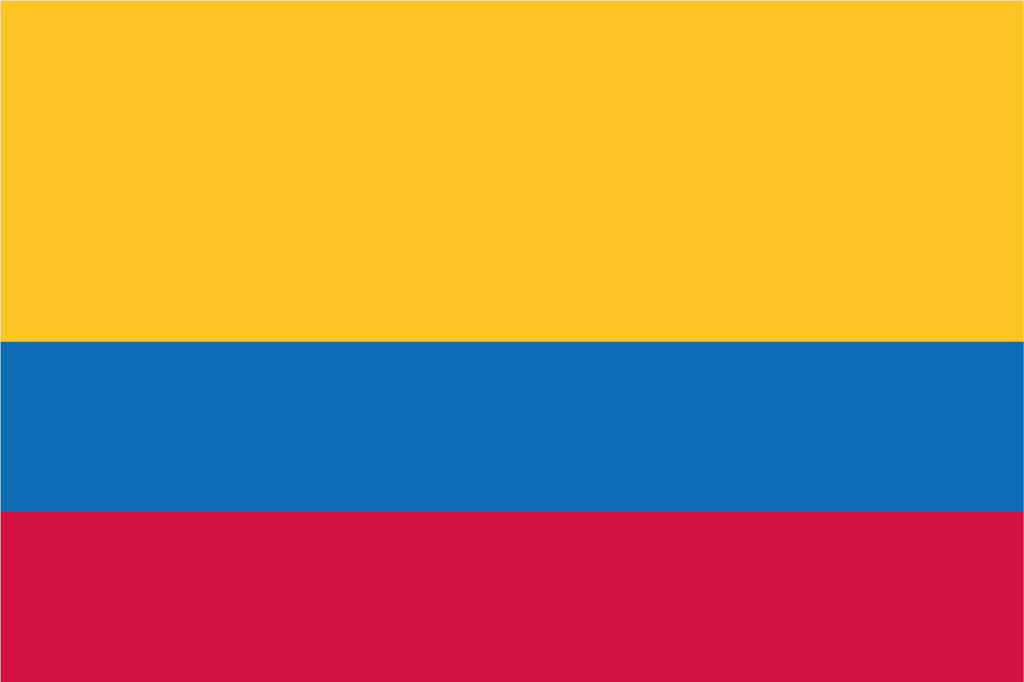

In [3]:
# testing

## to display an image from disk
from IPython.display import Image 

Image('flags/colombia.jpg')

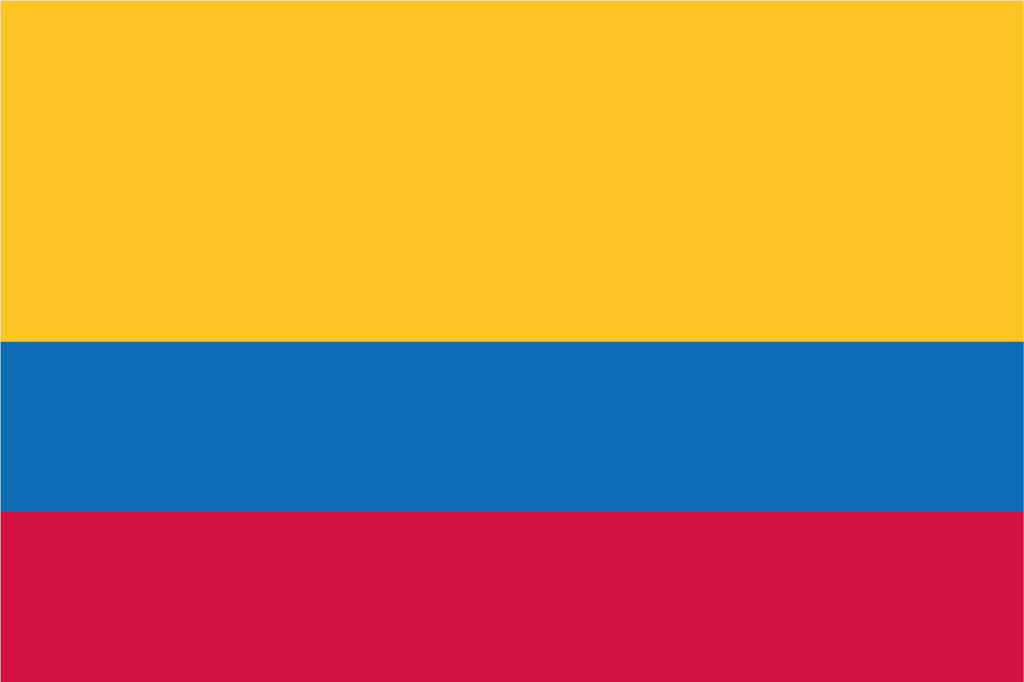

In [4]:
## to display an array as an image
colombia_bitmap = imread('flags/colombia.jpg')
PIL.Image.fromarray(colombia_bitmap)

# Import flag bitmaps as numpy arrays

In [5]:
flag_bitmaps = []

for flag in glob.glob('flags/*.jpg'):
    flag_bitmaps.append( imread(flag) )

# Normalize data

## Resize all flags to the proportions of the largest bounding box

In [6]:
flag_bitmap_shapes = [bitmap.shape for bitmap in flag_bitmaps]

max_first_dimension = max([shape[0] for shape in flag_bitmap_shapes])
max_second_dimension = max([shape[1] for shape in flag_bitmap_shapes])
max_third_dimension = max([shape[2] for shape in flag_bitmap_shapes])

max_bounding_box = (max_first_dimension, max_second_dimension, max_third_dimension)
print('Max bounding box: ({}, {}, {})'.format(*max_bounding_box))

Max bounding box: (684, 1025, 3)


In [7]:
reduced_max_bounding_box = (max_bounding_box[0] // 10, max_bounding_box[1] // 10, max_bounding_box[2])
print('Reduced size bounding box ({}, {}, {})'.format(*reduced_max_bounding_box))

Reduced size bounding box (68, 102, 3)


In [8]:
resized_flag_bitmaps = [imresize(bitmap, size=reduced_max_bounding_box) for bitmap in flag_bitmaps]

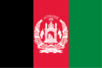

In [9]:
PIL.Image.fromarray(resized_flag_bitmaps[0])

## Flatten images, then create an input matrix

In [10]:
input_matrix = np.array([bitmap.flatten() for bitmap in resized_flag_bitmaps])

In [11]:
input_matrix.shape

(138, 20808)

## Subtract mean, divide by standard deviation along each pixel dimension

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaled_input_matrix = MinMaxScaler().fit_transform(input_matrix * 1.)

In [14]:
# scaled_input_matrix = zscore(input_matrix, axis=0)
# scaled_input_matrix /= scaled_input_matrix.max()
# scaled_input_matrix = input_matrix / 255.

# Instantiate network

In [15]:
from vanilla_neural_nets.autoencoder.sparse_autoencoder.network import VanillaSparseAutoencoder
from vanilla_neural_nets.neural_network.training_batch_generator import MiniBatchGenerator
from vanilla_neural_nets.autoencoder.sparse_autoencoder.optimization_algorithm import SparsityEnforcingGradientDescent
from vanilla_neural_nets.autoencoder.sparse_autoencoder.loss_function import SparseMeanSquaredError, KLDivergenceSparsityLoss
from vanilla_neural_nets.neural_network.activation_function import SigmoidActivationFunction
from vanilla_neural_nets.neural_network.parameter_initialization import GaussianWeightInitializer, GaussianBiasInitializer

In [16]:
N_HIDDEN_UNITS = 64
N_SAMPLES = scaled_input_matrix.shape[0]
N_FEATURES = scaled_input_matrix.shape[1]
LAYER_SIZES = [N_FEATURES, N_HIDDEN_UNITS, N_FEATURES]

In [22]:
LEARNING_RATE = .05
TRAINING_BATCH_SIZE = 72
N_EPOCHS = 300
RANDOM_STATE = 123
RHO = .05
BETA = .25
GAUSSIAN_INITIALIZATER_STANDARD_DEVIATION = 1. / np.sqrt(N_FEATURES)

In [23]:
training_set = scaled_input_matrix[:100, :]
validation_set = scaled_input_matrix[100:120, :]
test_set = scaled_input_matrix[120:, :]

In [24]:
class VanillaSparseAutoencoderWithLogging(VanillaSparseAutoencoder):
    
    def fit(self, X, y):
        for epoch in range(self.n_epochs):
            training_batch_generator = self.training_batch_generator_class(X=X, y=y, batch_size=self.training_batch_size,
                random_number_generator=self.random_number_generator)

            for training_batch in training_batch_generator:
                self.parameters = self._update_network_layers_with_training_batch(training_batch)
                
            if epoch % 25 == 0:
                print('Epoch: {}'.format(epoch))
                print('Training Loss: {}'.format( self._compute_loss(X=X, y=y)) )
                print('Validation Loss: {}'.format( self._compute_loss(X=validation_set, y=validation_set)) )
                print('Test Loss: {}'.format( self._compute_loss(X=test_set, y=test_set)) )
            
    def _compute_loss(self, X, y):
        predictions, mean_hidden_layer_activations = self.predict(X)
        return self.loss_function_class.loss(
            y_true=y,
            y_predicted=predictions,
            rho=RHO,
            vector_of_rho_hats=mean_hidden_layer_activations,
            beta=BETA
        )

In [25]:
network = VanillaSparseAutoencoderWithLogging(
    layer_sizes=LAYER_SIZES,
    training_batch_generator_class=MiniBatchGenerator,
    loss_function_class=SparseMeanSquaredError,
    activation_function_class=SigmoidActivationFunction,
    optimization_algorithm_class=SparsityEnforcingGradientDescent,
    sparsity_constraint_class=KLDivergenceSparsityLoss,
    learning_rate=LEARNING_RATE,
    n_epochs=N_EPOCHS,
    training_batch_size=TRAINING_BATCH_SIZE,
    random_state=RANDOM_STATE,
    rho=RHO,
    beta=BETA,
    weight_initializer=GaussianWeightInitializer(
        GAUSSIAN_INITIALIZATER_STANDARD_DEVIATION,
        random_state=RANDOM_STATE
    ),
    bias_initializer=GaussianBiasInitializer(
        GAUSSIAN_INITIALIZATER_STANDARD_DEVIATION,
        random_state=RANDOM_STATE
    )
)

# Train

In [26]:
network.fit(X=training_set, y=training_set)

Epoch: 0
Training Loss: 1486.7562528699661
Validation Loss: 1485.4838517040494
Test Loss: 1472.763803702074
Epoch: 25
Training Loss: 1256.662315700966
Validation Loss: 1349.126916559709
Test Loss: 1281.3919411703603
Epoch: 50
Training Loss: 1064.1362188434148
Validation Loss: 1236.6234936765727
Test Loss: 1158.586717176255
Epoch: 75
Training Loss: 972.3838042604336
Validation Loss: 1177.3061752624858
Test Loss: 1107.856354072315
Epoch: 100
Training Loss: 902.1127703162002
Validation Loss: 1128.9847949182154
Test Loss: 1070.7815902214097
Epoch: 125
Training Loss: 835.0693755963562
Validation Loss: 1082.4303413562618
Test Loss: 1041.6797428201305
Epoch: 150
Training Loss: 794.8128306572261
Validation Loss: 1066.3189449490642
Test Loss: 1023.3980790076063
Epoch: 175
Training Loss: 757.5079077449207
Validation Loss: 1045.2110653425939
Test Loss: 1001.5135366780793
Epoch: 200
Training Loss: 733.0682725853836
Validation Loss: 1022.1367959127381
Test Loss: 989.0339721258474
Epoch: 225
Trainin